# Anomaly Detection (Parking Floodlights)

Anomaly detection is used to identify data points that are considered abnormal to the pattern in the rest of the data. These data points are often referred to as outliers and can provide valuable insight into the state of a system. This Jupyter notebook demonstrates how to use the SAS Event Stream Processing ESPPy module to monitor energy consumption of parking floodlights on SAS campus.

Additional resources for this use case can be found at the SAS GiTHub page for [Anomaly Detection in Floodlights for Smart Campus](https://github.com/sassoftware/iot-anomaly-detection-floodlights).

### 0. Setup the environment

Import the necessary packages to run this notebook. Additionally, set the home directory, which tells the notebook where to save the model XML file.

In [1]:
import ipywidgets as widgets
import esppy
from esppy.espapi.visuals import Visuals
import csv
import requests
import time
import threading
import datetime
import io

Next, establish a connection with the ESP server.

In [2]:
esp = esppy.ESP('http://localhost:5001')
esp

ESP('http://localhost:5001')

Set the option <code>display.image_scale</code> equal to 0.75. Setting this option enables you to better visualize the project as you add more windows.

In [3]:
esppy.options.display.image_scale = 0.75

### 1. Create a project and continuous query

Create a project using <code>esp.create_project</code> and name it Parking_Floodlights.

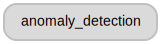

In [4]:
project = esp.create_project('anomaly_detection')
project

Now create a continuous query and call it <code>cq</code>. Add this query to your project. Continuous queries run automatically and periodically on streaming data. 

To learn more about continuous queries in SAS ESP, see [Continuous Queries](https://go.documentation.sas.com/?cdcId=espcdc&cdcVersion=6.2&docsetId=espstudio&docsetTarget=n05qoojb1v1ly3n1kkje39jmu7bb.htm&locale=en).

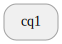

In [5]:
cq = esp.ContinuousQuery(name='cq1')
project.add_query(cq)

### 2. Create the project windows and define the workflow connections

#### _Source Window_

To start defining the streaming project, create a Source window and call it 'foodlights_data'. Source windows accept streaming data or raw data files. You create a schema that defines the data types in the Source window. 

To read more about Source windows, see [Input Streams](https://go.documentation.sas.com/?cdcId=espcdc&cdcVersion=6.2&docsetId=espcreatewindows&docsetTarget=p0g9m1aoxd1baxn14sndzo3hrkwg.htm&locale=en).

In [6]:
src = esp.SourceWindow(name='floodlights_data', pubsub='true', 
                       schema=('day:string', 'sequence_id*:int64',
                               'Light_1:double', 'Light_2:double',
                               'Light_3:double', 'Light_4:double',
                               'Light_5:double', 'Light_6:double'),
                       index_type='empty', insert_only=True)

Create a connector for the Source window that publishes your data, and add that Source window to your continuous query. 

To read more about connectors, see [Overview to Connectors](https://go.documentation.sas.com/?cdcId=espcdc&cdcVersion=6.2&docsetId=espca&docsetTarget=p1nhdjrc9n0nnmn1fxqnyc0nihzz.htm&locale=en).

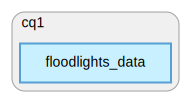

In [7]:
src.add_connector(conn_cls='fs', conn_name='pub', 
                  conn_type='publish', type='pub', fstype='csv',
                  fsname='/demo/Event_Stream_Processing/data/parking_floodlights_data.csv',
                  blocksize=1, header=1, addcsvopcode=True,
                  addcsvflags='normal', rate=10,repeatcount=200)

cq.add_window(src)

cq

Optionally, you can submit the name of a window to view its schema. Here, you submit <code>src</code> which produces the schema for the Source window you created.

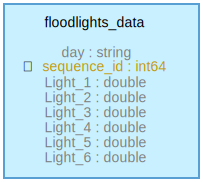

In [8]:
src

#### _Calculate Window_

Create a Calculate window that uses the Subspace Tracking algorithm. The Subspace Tracking (SST) algorithm is packaged in SAS Event Stream Processing to detect outliers in real time on streaming data. It is a method to detect anomalies and degradation in systems that generate high-frequency, high-dimensional data.

To read more about Calculate windows, see [Using Calculate Windows](https://go.documentation.sas.com/?cdcId=espcdc&cdcVersion=6.2&docsetId=espcreatewindows&docsetTarget=n1n1erunro8yqgn16fiqs1tn17fn.htm&locale=en). 

To know more about the SST algorithm, see [Subspace Tracking](https://go.documentation.sas.com/?cdcId=espcdc&cdcVersion=6.2&docsetId=espan&docsetTarget=n0jveogr5iwzyxn1w7imhj73d4zf.htm&locale=en#p0dv9t241gp1ptn13vo75aol2d1ba).

Next, add the Calculate window to the continuous query, defining calculation parameters and mapping definitions.

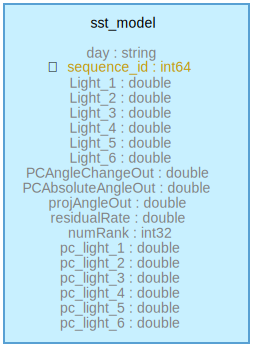

In [9]:
calc = esp.CalculateWindow(name='sst_model', algorithm='SST',
                           schema=('day:string', 'sequence_id*:int64',
                               'Light_1:double', 'Light_2:double',
                               'Light_3:double', 'Light_4:double',
                               'Light_5:double', 'Light_6:double',
                               'PCAngleChangeOut:double', 'PCAbsoluteAngleOut:double',
                               'projAngleOut:double', 'residualRate:double',
                               'PCAngleChangeOut:double', 'PCAbsoluteAngleOut:double',
                               'numRank:int32', 
                               'pc_light_1:double', 'pc_light_2:double',
                               'pc_light_3:double', 'pc_light_4:double',
                               'pc_light_5:double', 'pc_light_6:double'))

calc.set_parameters(windowLength=240, overlap=-1,
                    maxPrincipal=2, covForgetFactor=0.5,
                    meanForgetFactor=0.5,eigvalTolCumulative=0.99)

calc.set_inputs(inputs=['Light_1', 'Light_2', 'Light_3', 'Light_4', 'Light_5', 'Light_6'])
                                     
calc.set_outputs(PCAngleChangeOut='PCAngleChangeOut',
                 PCAbsoluteAngleOut='PCAbsoluteAngleOut',
                 projAngleOut='projAngleOut',
                 residualOut='residualRate',
                 numRankOut='numRank',
                 principalVecOut=['pc_light_1', 'pc_light_2', 'pc_light_3', 'pc_light_4', 'pc_light_5', 'pc_light_6'])

calc

Create a connector for the Calculate window that subscribes your data, and add that Calculate window to your continuous query. Connectors publish event streams (data) into Source windows.

To read more about connectors, see [Overview to Connectors](https://go.documentation.sas.com/?cdcId=espcdc&cdcVersion=6.2&docsetId=espca&docsetTarget=p1nhdjrc9n0nnmn1fxqnyc0nihzz.htm&locale=en).

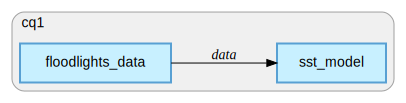

In [10]:
calc.add_connector(conn_cls='fs', conn_name='sub', 
                   conn_type='subscribe', type='sub', header='full', fstype='csv',
                   fsname='/user/my_data/esp_sst_out.csv',
                   snapshot='true')

cq.add_window(calc)

src.add_target(calc, role='data')

cq

#### _Compute Window_

Now, create a Compute window that adds a flag to detect differences on PCAngleChangeOut abovee 0.0008. Name this Compute window _gflag_ and add it to the continuous query. 

To read more about Compute windows, see [Using Compute Windows](https://go.documentation.sas.com/?cdcId=espcdc&cdcVersion=6.2&docsetId=espcreatewindows&docsetTarget=p0az3u020i6o7an14agtsdk1st0v.htm&locale=en).

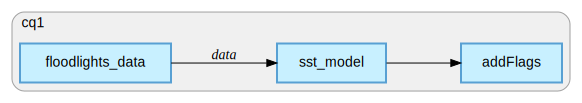

In [11]:
gflag = esp.ComputeWindow(name='addFlags',
                          schema=('day:string', 'sequence_id*:int64',
                                  'Light_1:double', 'Light_2:double',
                                  'Light_3:double', 'Light_4:double',
                                  'Light_5:double', 'Light_6:double',
                                  'PCAngleChangeOut:double', 'PCAbsoluteAngleOut:double',
                                  'projAngleOut:double', 'residualRate:double',
                                  'numRank:int32', 
                                  'pc_light_1:double', 'pc_light_2:double',
                                  'pc_light_3:double', 'pc_light_4:double',
                                  'pc_light_5:double', 'pc_light_6:double',
                                  'Flag:double'))

gflag.add_field_expressions('day', 
                            'Light_1', 'Light_2', 'Light_3',
                            'Light_4', 'Light_5', 'Light_6',
                            'PCAngleChangeOut', 'PCAbsoluteAngleOut',
                            'projAngleOut', 'residualRate',
                            'numRank', 
                            'pc_light_1', 'pc_light_2', 'pc_light_3',
                            'pc_light_4', 'pc_light_5', 'pc_light_6',
                            'if (PCAngleChangeOut>0.0008) then return 1 else return 0')

cq.add_window(gflag)

calc.add_target(gflag)

cq

#### _Filter Window_

Finallt, add a Filter window that selects only the events with Flag=1 (differences on PCAngleChangeOut above 0.0008) and call the window _filt_. Add this window to the continuous query.

To learn more about Filter windows, see [Using Filter Windows](https://go.documentation.sas.com/?cdcId=espcdc&cdcVersion=6.2&docsetId=espcreatewindows&docsetTarget=p1laytbc862ix9n1w5rm9reywors.htm&locale=en).

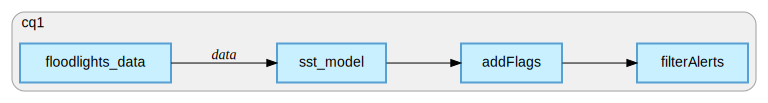

In [12]:
filt = esp.FilterWindow(name='filterAlerts')
filt.set_expression('Flag==1') 
cq.add_window(filt)

gflag.add_target(filt)

cq

### 3. Save Project to XML

You have the option of saving the project you created to an XML file. Here, you save the 'parking_floodlights_esppy_model.xml' to the _my_code_ folder of your home directory. This is an optional step.

In [13]:
project.save_xml('/user/my_code/anomaly_detection_esppy.xml')

### 4. Load project into ESP server

Next, load the project to the esp server using <code>esp.load_project</code> and start the streaming project using <code>project.start()</code>.

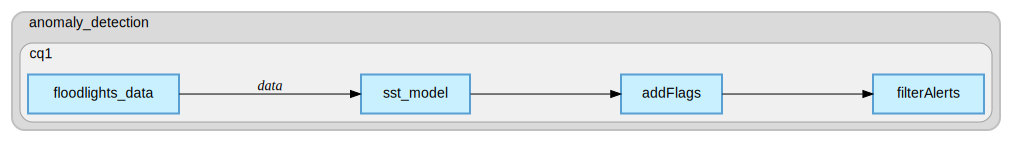

In [14]:
esp.load_project(project)

In [15]:
project.start()

### 5. Generate plots and dashboard of the data being streamed

To quickly verify that the data is streaming correctly, you can use open source components to subscribe to any window of the project. In this case you are subscribing to the Source window and creating a visual to view the data as it streams through your project.

Initially you define the visual parameters for the output to be generated by PLOTLY and establish a connection for the GUI to access the data stream.

In [16]:
visuals = Visuals(colormap="sas_corporate", border="1px solid blue")
conn = esp.createServerConnection()

Use the established connection to subscribe to the windows of the project and review the data on them. 

Plot 1 (Energy Consumption of Floodlights) enables you to visualize the energy consumption (in kilowatts) of the floodlights. It shows that the energy consumption throughout the day is zero because the lights are off during daylight hours. Light 2 has a dip in energy consumption for a couple of hours on the sixth night, indicating that  one of the lights controlled by the circuit is not functioning properly.

Plot 2 (Angle Change) displays the angle change of the first principal component between consecutive time windows calculated using Subspace Tracking method. The dip in energy consumption of Light 2 is captured by spike in angle change plot on day 6, which can help in detecting when a light circuit is not functioning properly.

In [17]:
pf_src = conn.getEventStream("anomaly_detection/cq1/floodlights_data", maxevents=200)
pf_sst = conn.getEventStream("anomaly_detection/cq1/sst_model", maxevents=200)

light_chart = visuals.createTimeSeries(pf_src, time=["sequence_id"], y=["Light_1","Light_2","Light_3","Light_4","Light_5","Light_6"], 
                                  title="Energy Consumption of Floodlights (in kW)", fill=False, curve=True, show_controls=True, width="75%")
angle_chart = visuals.createTimeSeries(pf_sst, time=["sequence_id"], y=["PCAngleChangeOut"], 
                                  title="Angle Change", fill=True, curve=True, show_controls=True, width="75%")

widgets.VBox([light_chart,angle_chart])

### 6. Cleanup Your Project

It is recommended to delete your project after you are finished viewing it. To do this, uncomment the following line of code, and execute it to end your project.

In [18]:
# project.delete()